In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# load local version of skaro, before pip installed version, for debugging
import pathlib
import sys
import os

sys.path.append(str(pathlib.Path(os.getcwd()).parent.joinpath("src")))

In [3]:
import yt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from skaro.model import Model
from skaro.utilities.math import calculate_pca
from skaro.utilities.dataframe import (
    aggregated_dataframe,
    rename_labels,
    rename_entries,
)
from skaro.visualization.visualization_utils import (
    set_plot_defaults,
    get_palette,
    FigureProcessor,
    ridgeplot,
)

## DATA SETUP

In [4]:
snapshot = 127
resolution = 8192
sim_id = "37_11"

In [5]:
model = Model(
    snapshot=snapshot,
    resolution=resolution,
    sim_id=sim_id,
)
ds = model.ds
mw = model.halo


      DETECTED LOCAL MACHINE: Test snapshot loaded.


      CONFIG: Setting resolution to 4096.


      CONFIG: Setting sim_id to 09_18.

yt : [INFO     ] 2024-02-08 13:49:28,159 Calculating time from 1.000e+00 to be 4.318e+17 seconds
yt : [INFO     ] 2024-02-08 13:49:28,232 Parameters: current_time              = 4.318436660023809e+17 s
yt : [INFO     ] 2024-02-08 13:49:28,232 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-02-08 13:49:28,233 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-02-08 13:49:28,233 Parameters: domain_right_edge         = [100. 100. 100.]
yt : [INFO     ] 2024-02-08 13:49:28,234 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-08 13:49:28,235 Parameters: current_redshift          = 4.440892098500626e-16
yt : [INFO     ] 2024-02-08 13:49:28,236 Parameters: omega_lambda              = 0.682
yt : [INFO     ] 2024-02-08 13:49:28,236 Parameters: omega_matter              = 0.318
yt : [INFO     ] 

## PLOT SETUP

In [6]:
set_plot_defaults()

figure_subdirectory = f"MilkyWayAnalogue/{model.resolution}/{model.sim_id}/{model.snapshot}/Galaxy_components"
save = True

## CREATE DATA SOURCE

In [7]:
radius = 0.2 * mw.virial_radius()
sphere_data = mw.sphere(radius=radius)

In [8]:
components = ["bulge_stars", "thin_disk_stars", "thick_disk_stars", "halo_stars"]
data = aggregated_dataframe(
    components,
    [
        "[Fe/H]",
        "stellar_age",
        "Masses",
    ],
    data_source=sphere_data,
    type_name="Component",
    custom_units={"stellar_age": "Gyr"},
)

# filtering values
filters = {"[Fe/H]": (-2.5, 1)}
for field_value, ranges in filters.items():
    data = data[data[field_value].between(*ranges)]

# rename labels and components
data = rename_entries(data)
data, labels = rename_labels(data)

## FRACTION OF MASS IN COMPONENTS

In [9]:
data.groupby("Component")["Masses"].sum()

Component
Bulge         1.907084e+10
Halo          9.407519e+09
Thick Disk    1.945586e+08
Thin Disk     3.721746e+10
Name: Masses, dtype: float64

In [10]:
data.groupby("Component")["Masses"].sum() / data["Masses"].sum()

Component
Bulge         0.289433
Halo          0.142775
Thick Disk    0.002953
Thin Disk     0.564839
Name: Masses, dtype: float64

## STELLAR AGE IN COMPONENTS

In [11]:
data.groupby("Component")[labels["stellar_age"]].describe().T

Component,Bulge,Halo,Thick Disk,Thin Disk
count,106838.000000,48065.000000,1000.000000,191037.000000
mean,7.251716,7.626551,7.681459,3.447196
std,3.213330,3.216894,2.915591,2.577433
min,0.020130,0.020130,0.164111,0.020130
25%,4.771484,5.909042,6.079812,1.412831
50%,7.792287,7.339422,7.005829,2.927751
75%,9.565670,9.915462,9.805700,4.836606
max,13.462528,13.361374,13.325122,13.448053


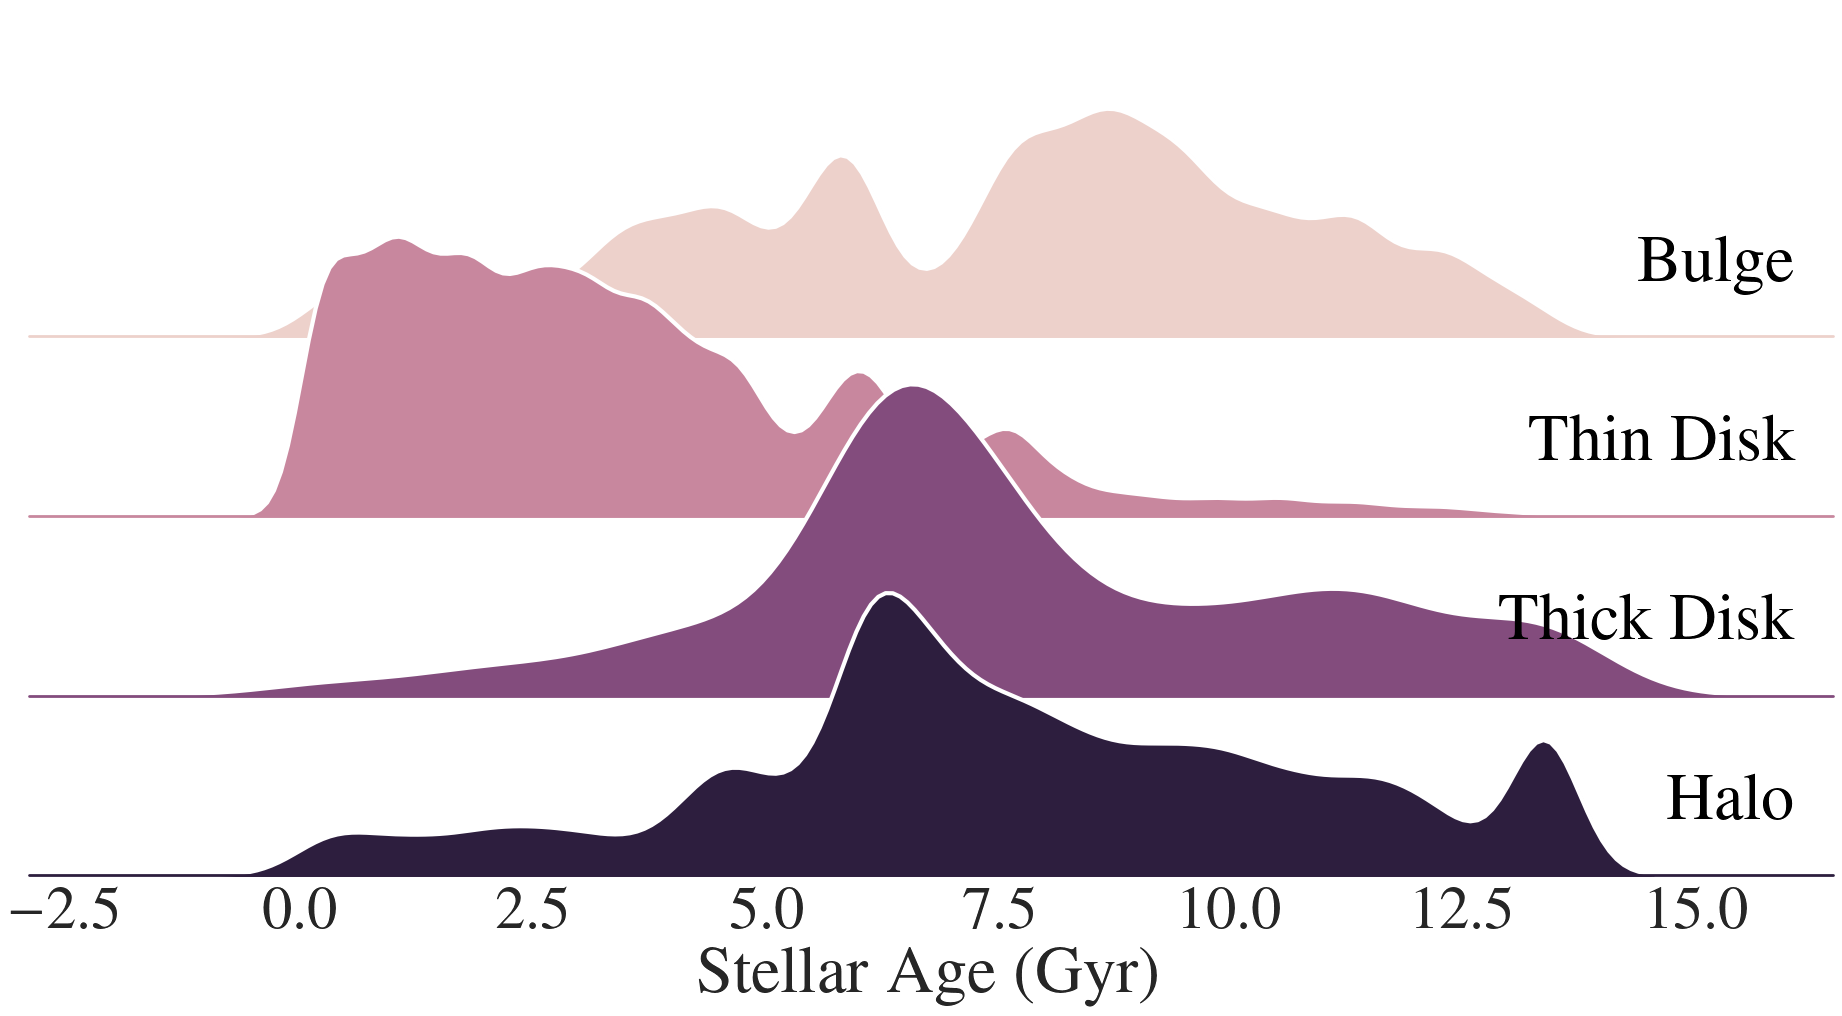

In [12]:
ridgeplot_age = ridgeplot(
    data,
    x=labels["stellar_age"],
    row="Component",
    palette=get_palette(n_colors=4),
    label_position=[0.98, 0.22],
)
FigureProcessor(ridgeplot_age.figure).save(
    "ridgeplot_age.pdf",
    sub_directory=figure_subdirectory,
    save=save,
)

## METALLICITY IN COMPONENTS

In [13]:
data.groupby("Component")["[Fe/H]"].describe().T

Component,Bulge,Halo,Thick Disk,Thin Disk
count,106838.000000,48065.000000,1000.000000,191037.000000
mean,-0.133771,-0.493346,-0.575053,-0.008703
std,0.436933,0.432867,0.392142,0.311904
min,-2.493953,-2.497246,-2.428581,-2.474091
25%,-0.423398,-0.694959,-0.744882,-0.201515
50%,-0.096739,-0.426410,-0.518611,0.008891
75%,0.198362,-0.211662,-0.343986,0.221802
max,0.719918,0.840895,0.497816,0.718245


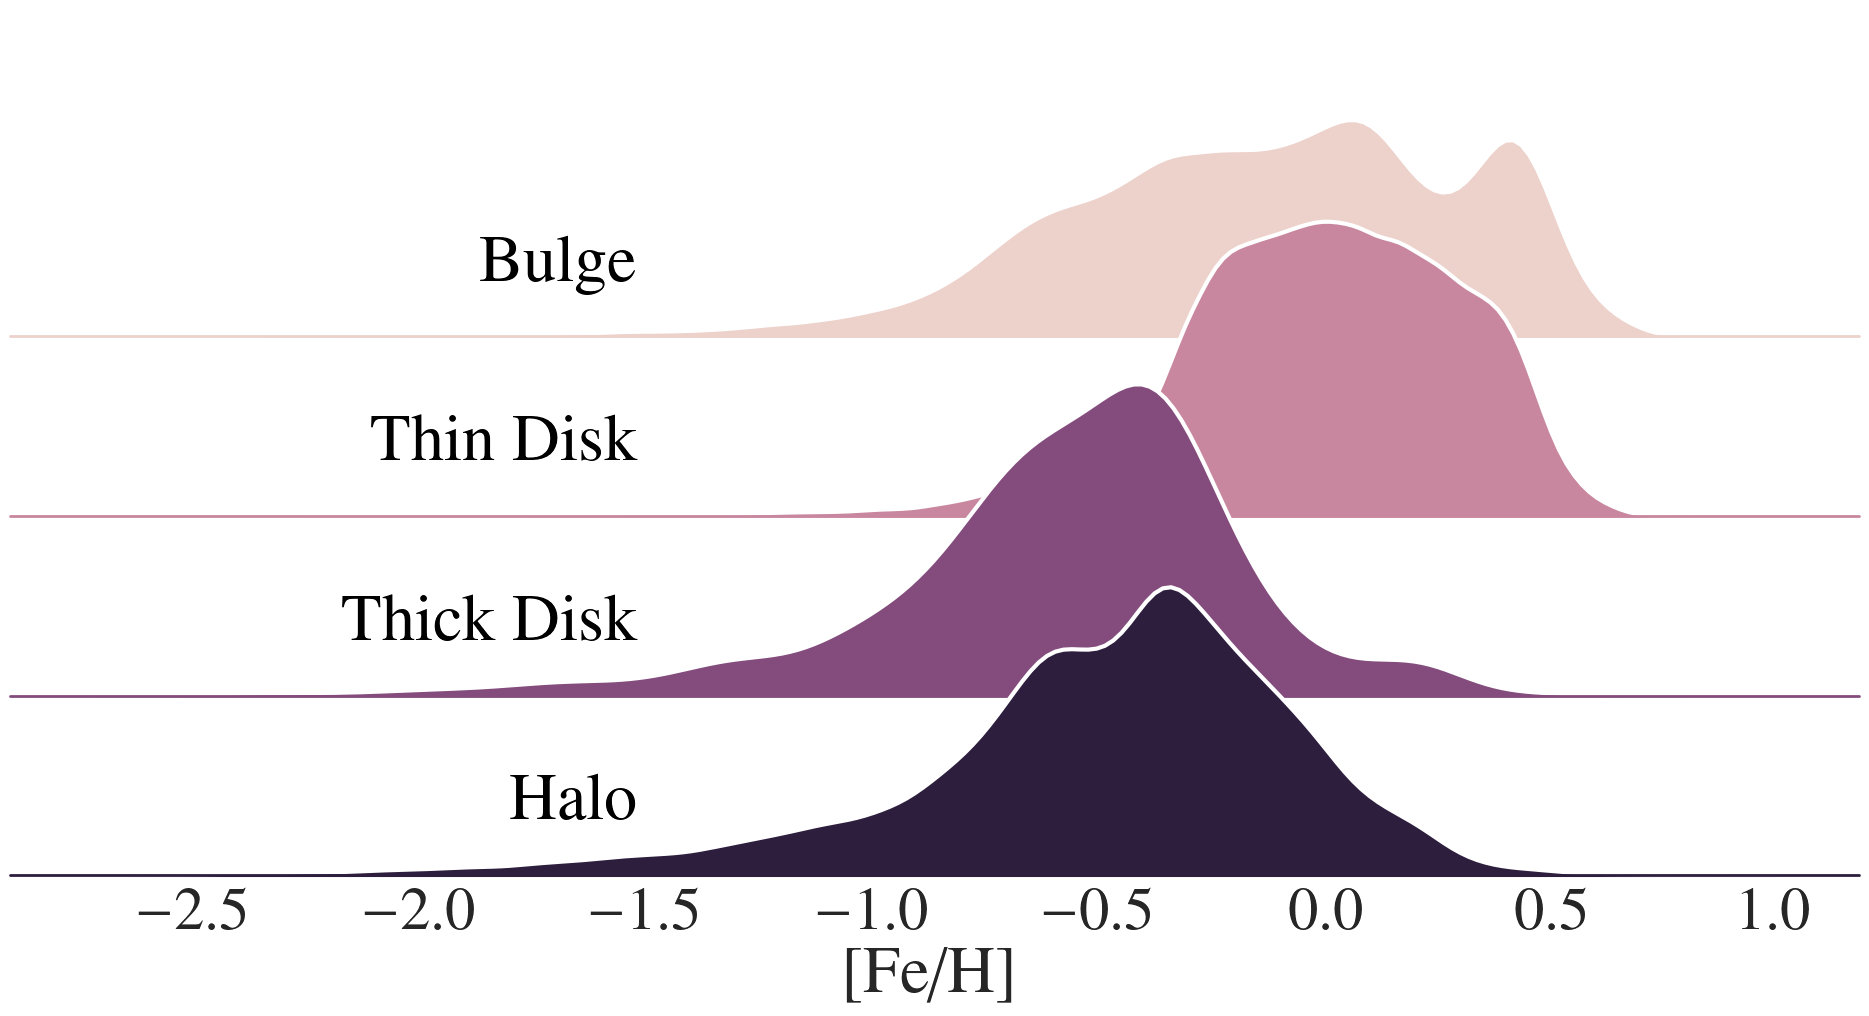

In [14]:
ridgeplot_metallicity = ridgeplot(
    data,
    x=labels["[Fe/H]"],
    row="Component",
    palette=get_palette(n_colors=4),
    label_position=[0.34, 0.22],
)
FigureProcessor(ridgeplot_metallicity.figure).save(
    "ridgeplot_metallicity.pdf",
    sub_directory=figure_subdirectory,
    save=save,
)

## PRICIPAL COMPONENTS

In [15]:
variance_ratios = pd.DataFrame(
    np.array(
        [
            calculate_pca(
                sphere_data[component, "particle_position"].to("kpc")
            ).explained_variance_ratio_
            for component in components
        ]
    ).T,
    columns=components,
).T

print("Minor-to-major axis ratio:")
print(variance_ratios[2] / variance_ratios[0])

Minor-to-major axis ratio:
bulge_stars         0.396159
thin_disk_stars     0.076264
thick_disk_stars    0.387752
halo_stars          0.574847
dtype: float64
